In [4]:
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import graphviz

In [6]:
file_path = 'smoking_driking_dataset_Ver01.csv'
column_names = [ 'sex', 'age', 'height', 'weight', 'waistline',
    'sight_left', 'sight_right',
    'hear_left', 'hear_right',
    'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
    'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine',
    'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN'
]

# Load the dataset with specified column names
df = pd.read_csv(file_path, header=0, names=column_names)
# Display the first few rows of the dataframe
#print(df.head())

# Drop rows with any missing values
df = df.dropna()
print(len(df))



991346


In [8]:
# Select random 100,000 records from the dataframe
sample_df = df.sample(n=100000, random_state=1)

# Save the sampled dataframe to a new CSV file
sample_file_path = 'smoking_driking_dataset_sampled.csv'
sample_df.to_csv(sample_file_path, index=False)

sample_df.head()
sample_df_no_feature_engg = sample_df.copy()
sample_df_no_feature_engg2 = sample_df.copy()
sample_df_no_feature_engg3 = sample_df.copy()
sample_df_no_feature_engg4 = sample_df.copy()
sample_df_no_feature_engg5 = sample_df.copy()
sample_df_no_feature_engg6 = sample_df.copy()
sample_df_no_feature_engg.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
921688,Female,50,155,60,82.0,0.7,0.5,1.0,1.0,130.0,...,95.0,193.0,14.0,1.0,0.7,30.0,26.0,35.0,1.0,Y
56603,Female,55,155,50,73.2,1.0,0.8,1.0,1.0,115.0,...,132.0,39.0,12.9,1.0,0.6,25.0,18.0,14.0,1.0,N
434962,Female,60,160,60,78.0,0.6,0.8,1.0,1.0,97.0,...,90.0,57.0,13.3,1.0,0.7,21.0,16.0,11.0,1.0,N
742617,Male,35,175,80,94.0,1.2,1.2,1.0,1.0,121.0,...,128.0,258.0,15.3,1.0,0.6,19.0,27.0,31.0,3.0,Y
604547,Male,45,160,60,82.1,0.9,0.8,1.0,1.0,135.0,...,99.0,115.0,14.8,1.0,0.9,17.0,28.0,48.0,1.0,Y


In [10]:
# FEATURE ENGINEERING

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'hemoglobin',
                      'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']
sample_df[numerical_features] = scaler.fit_transform(sample_df[numerical_features])
#print(sample_df.head())

# new column 'Hearing_State'
sample_df['Hearing_State'] = df.apply(lambda row: 2 if row['hear_left'] == 2 or row['hear_right'] == 2 else 1, axis=1)

# new column 'Sight_State'
#sample_df['Sight_State'] = df.apply(lambda row: 2 if row['sight_left'] == 2 or row['sight_right'] == 2 else 1, axis=1)

# new column 'HDL_LDL_ratio'
sample_df['HDL_LDL_Ratio'] = sample_df['HDL_chole'] / sample_df['LDL_chole']

# new column 'BMI'
sample_df['BMI'] = sample_df['weight'] / ((sample_df['height'] / 100) ** 2)

# new column 'Total_HDL_ratio'
sample_df['Total_HDL_Ratio'] = sample_df['tot_chole'] / sample_df['HDL_chole']

# new column 'Liver_Enzyme_Ratio' (SGOT:SGPT)
sample_df['Liver_Enzyme_Ratio'] = sample_df['SGOT_AST'] / sample_df['SGOT_ALT']

#Smoked [1], Never Smoked [0]
# Categorize smoking status
sample_df['Smoking_Status'] = sample_df['SMK_stat_type_cd'].apply(lambda x: '0' if x == 1 else '1')

# Categorize drinking status
sample_df['Drinking_Status'] = sample_df['DRK_YN'].apply(lambda x: '0' if x == 'N' else '1')

sample_df['liver_damage_score'] = sample_df['gamma_GTP'] + sample_df['SGOT_ALT']


sample_df['Drinking_Status'] = pd.to_numeric(sample_df['Drinking_Status'])


sample_df['Smoking_Status'] = pd.to_numeric(sample_df['Smoking_Status'])

#Has ever been into drinking or smoking
sample_df['DorS'] = sample_df.apply(lambda row: 1 if row['Smoking_Status'] == 1 or row['Drinking_Status'] == 1 else 0, axis=1)

sample_df_fe = sample_df.copy()
sample_df[:5]
#len(sample_df)

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,DRK_YN,Hearing_State,HDL_LDL_Ratio,BMI,Total_HDL_Ratio,Liver_Enzyme_Ratio,Smoking_Status,Drinking_Status,liver_damage_score,DorS
921688,Female,50,155,60,82.0,0.7,0.5,1.0,1.0,0.521217,...,Y,1,-3.045653,24.973985,0.315012,6.448453,0,1,-0.022885,1
56603,Female,55,155,50,73.2,1.0,0.8,1.0,1.0,-0.508473,...,N,1,1.127806,20.811655,0.454888,0.080905,0,0,-0.796735,0
434962,Female,60,160,60,78.0,0.6,0.8,1.0,1.0,-1.744101,...,N,1,-1.037596,23.437500,-1.081401,0.329893,0,0,-0.945066,0
742617,Male,35,175,80,94.0,1.2,1.2,1.0,1.0,-0.096597,...,Y,1,-1.261110,26.122449,-1.650104,-3.175189,1,1,-0.059040,1
604547,Male,45,160,60,82.1,0.9,0.8,1.0,1.0,0.864448,...,Y,1,2.887429,23.437500,0.777988,-2.383707,0,1,0.326028,1


In [178]:
sample_df_fe[:5]

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,SMK_stat_type_cd,DRK_YN,Hearing_State,HDL_LDL_Ratio,BMI,Total_HDL_Ratio,Liver_Enzyme_Ratio,Smoking_Status,Drinking_Status,DorS
921688,Female,50,155,60,82.0,0.7,0.5,1.0,1.0,0.521217,...,1.0,Y,1,-3.045653,24.973985,0.315012,6.448453,0,1,1
56603,Female,55,155,50,73.2,1.0,0.8,1.0,1.0,-0.508473,...,1.0,N,1,1.127806,20.811655,0.454888,0.080905,0,0,0
434962,Female,60,160,60,78.0,0.6,0.8,1.0,1.0,-1.744101,...,1.0,N,1,-1.037596,23.437500,-1.081401,0.329893,0,0,0
742617,Male,35,175,80,94.0,1.2,1.2,1.0,1.0,-0.096597,...,3.0,Y,1,-1.261110,26.122449,-1.650104,-3.175189,1,1,1
604547,Male,45,160,60,82.1,0.9,0.8,1.0,1.0,0.864448,...,1.0,Y,1,2.887429,23.437500,0.777988,-2.383707,0,1,1


Shift the data and set up the training and test set

In [52]:
#Decision trees drinker
sample_df_no_feature_engg['DRK_YN'] = sample_df_no_feature_engg['DRK_YN'].apply(lambda x: 1 if x == 'Y' else 0)
Y, X = dmatrices('DRK_YN ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + SMK_stat_type_cd', sample_df_no_feature_engg, return_type='dataframe')
y = Y['DRK_YN'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
sample_df_no_feature_engg.head()


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
921688,Female,50,155,60,82.0,0.7,0.5,1.0,1.0,130.0,...,95.0,193.0,14.0,1.0,0.7,30.0,26.0,35.0,1.0,1
56603,Female,55,155,50,73.2,1.0,0.8,1.0,1.0,115.0,...,132.0,39.0,12.9,1.0,0.6,25.0,18.0,14.0,1.0,0
434962,Female,60,160,60,78.0,0.6,0.8,1.0,1.0,97.0,...,90.0,57.0,13.3,1.0,0.7,21.0,16.0,11.0,1.0,0
742617,Male,35,175,80,94.0,1.2,1.2,1.0,1.0,121.0,...,128.0,258.0,15.3,1.0,0.6,19.0,27.0,31.0,3.0,1
604547,Male,45,160,60,82.1,0.9,0.8,1.0,1.0,135.0,...,99.0,115.0,14.8,1.0,0.9,17.0,28.0,48.0,1.0,1


Set up the tree model

In [54]:
model = tree.DecisionTreeClassifier(criterion='entropy')

In [56]:
result = model.fit(X_train, y_train)

In [58]:
prediction_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

1.0


In [60]:
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.6436


In [62]:
model2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
result = model2.fit(X_train, y_train)

In [64]:
prediction_train = model2.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.6822714285714285


In [66]:
prediction = model2.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.6867666666666666


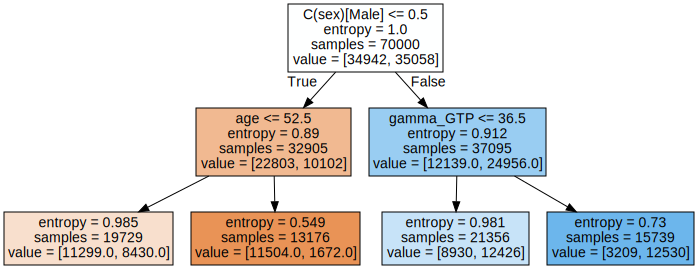

In [70]:
graphviz.Source(tree.export_graphviz(model2,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

In [76]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    model3 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model3, X_train, y_train, cv=kfold)
    print('max_depth={} scores={} avg_score={}'.format(max_depth, scores, scores.mean()))
    #It kind of levels out around 3 so we will go with that

max_depth=1 scores=[0.68222337 0.6827669  0.68182403] avg_score=0.6822714292580602
max_depth=2 scores=[0.68273764 0.68315262 0.68092401] avg_score=0.6822714219112264
max_depth=3 scores=[0.70060855 0.69695281 0.70766725] avg_score=0.7017428733474187
max_depth=4 scores=[0.70866547 0.70899584 0.69780997] avg_score=0.7051570927375148
max_depth=5 scores=[0.71697951 0.71315305 0.71508164] avg_score=0.7150714013126634
max_depth=6 scores=[0.71273678 0.71645309 0.71812454] avg_score=0.7157714719241853
max_depth=7 scores=[0.71629382 0.72416749 0.72056744] avg_score=0.7203429149870688
max_depth=8 scores=[0.7230222  0.71388163 0.72078173] avg_score=0.7192285172331124
max_depth=9 scores=[0.71890803 0.71332448 0.71576737] avg_score=0.7159999584561038
max_depth=10 scores=[0.70982258 0.71298161 0.7120816 ] avg_score=0.7116285972288675
max_depth=11 scores=[0.70553698 0.71191017 0.70466721] avg_score=0.7073714547781446
max_depth=12 scores=[0.70035142 0.70055287 0.70338148] avg_score=0.7014285868166898
m

In [78]:
model3 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
result = model3.fit(X_train, y_train)

In [80]:
prediction_train = model3.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.7058285714285715


In [82]:
prediction = model3.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.7060666666666666


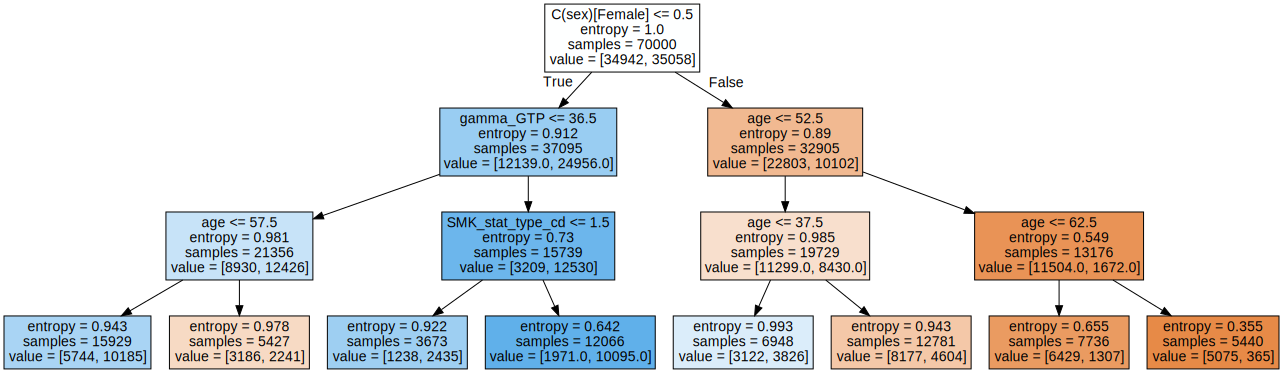

In [84]:
graphviz.Source(tree.export_graphviz(model3,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

In [ ]:
########################################################################################################

In [144]:
# Base Model: Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
sample_df_no_feature_engg['DRK_YN'] = sample_df_no_feature_engg['DRK_YN'].apply(lambda x: 1 if x == 'Y' else 0)
Y, X = dmatrices('DRK_YN ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP', sample_df_no_feature_engg, return_type='dataframe')
y = Y['DRK_YN'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('max_depth={} avg_score={}'.format(max_depth, scores.mean()))
    #Pick the most simple where it starts leveling out

max_depth=1 avg_score=0.6822714285714286
max_depth=2 avg_score=0.6822714285714286
max_depth=3 avg_score=0.7017714285714286
max_depth=4 avg_score=0.7053714285714285
max_depth=5 avg_score=0.7102142857142857
max_depth=6 avg_score=0.7140714285714286
max_depth=7 avg_score=0.7143857142857143
max_depth=8 avg_score=0.7133428571428572
max_depth=9 avg_score=0.7109
max_depth=10 avg_score=0.7073142857142858
max_depth=11 avg_score=0.7020571428571427
max_depth=12 avg_score=0.6999285714285715
max_depth=13 avg_score=0.6933857142857143
max_depth=14 avg_score=0.6865285714285714
max_depth=15 avg_score=0.6776142857142856


0.7123333333333334


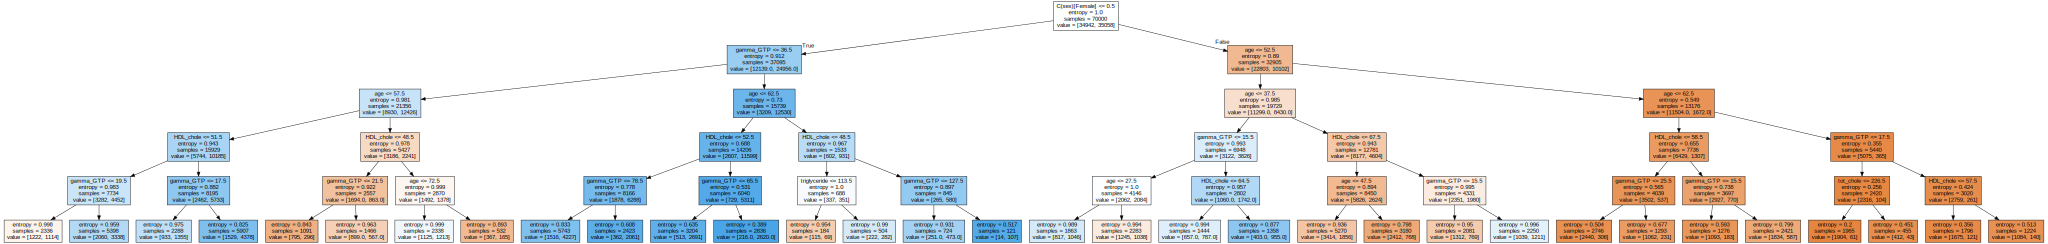

In [104]:
#Don't forget to rename the model and set the max depth
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

#For this it is blue is more positive and red it more negative, white or tan is no split

In [ ]:
##########################################################################################################

In [148]:
# Base Model: Smokers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
sample_df_no_feature_engg2['SMK_stat_type_cd'] = sample_df_no_feature_engg2['SMK_stat_type_cd'].apply(lambda x: 0 if x == 1 else 1)
Y, X = dmatrices('SMK_stat_type_cd ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP', sample_df_no_feature_engg2, return_type='dataframe')
y = Y['SMK_stat_type_cd'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('max_depth={} avg_score={}'.format(max_depth, scores.mean()))
    #Pick the most simple where it starts leveling out

max_depth=1 avg_score=0.8056000000000001
max_depth=2 avg_score=0.8055999999999999
max_depth=3 avg_score=0.8054
max_depth=4 avg_score=0.8083571428571428
max_depth=5 avg_score=0.8080571428571428
max_depth=6 avg_score=0.8076857142857143
max_depth=7 avg_score=0.806
max_depth=8 avg_score=0.8053857142857144
max_depth=9 avg_score=0.8039142857142856
max_depth=10 avg_score=0.8005285714285714
max_depth=11 avg_score=0.7966714285714286
max_depth=12 avg_score=0.7948857142857143
max_depth=13 avg_score=0.7900857142857143
max_depth=14 avg_score=0.7851
max_depth=15 avg_score=0.780142857142857


0.8095666666666667


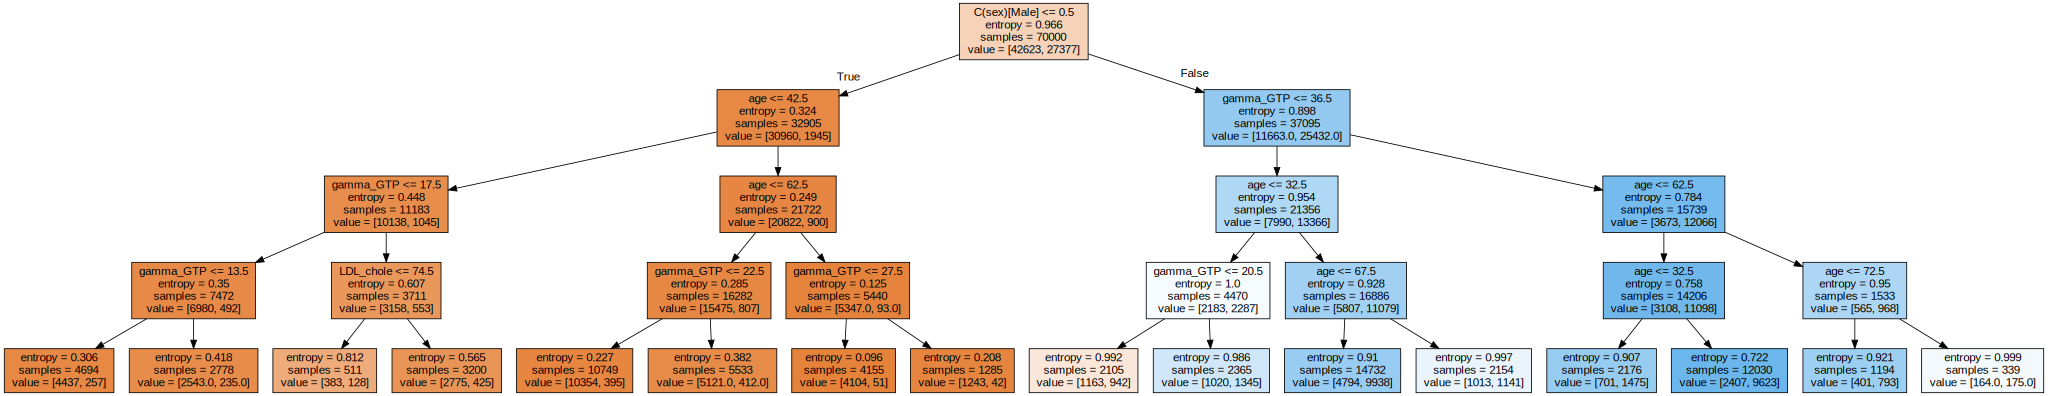

In [149]:
#Don't forget to rename the model and set the max depth
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

#For this it is blue is more positive and red it more negative, white or tan is no split

In [ ]:
#############################################################################################################

In [237]:
# FE Model: Smokers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('Smoking_Status ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['Smoking_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('max_depth={} avg_score={}'.format(max_depth, scores.mean()))
    #Pick the most simple where it starts leveling out

max_depth=1 avg_score=0.8056000000000001
max_depth=2 avg_score=0.8055999999999999
max_depth=3 avg_score=0.8057285714285713
max_depth=4 avg_score=0.8082
max_depth=5 avg_score=0.8084714285714286
max_depth=6 avg_score=0.8064285714285713
max_depth=7 avg_score=0.8068142857142858
max_depth=8 avg_score=0.8035
max_depth=9 avg_score=0.8019714285714284
max_depth=10 avg_score=0.7993285714285715
max_depth=11 avg_score=0.7959714285714286
max_depth=12 avg_score=0.7935
max_depth=13 avg_score=0.7884857142857142
max_depth=14 avg_score=0.7831857142857144
max_depth=15 avg_score=0.7797999999999999


0.8095666666666667


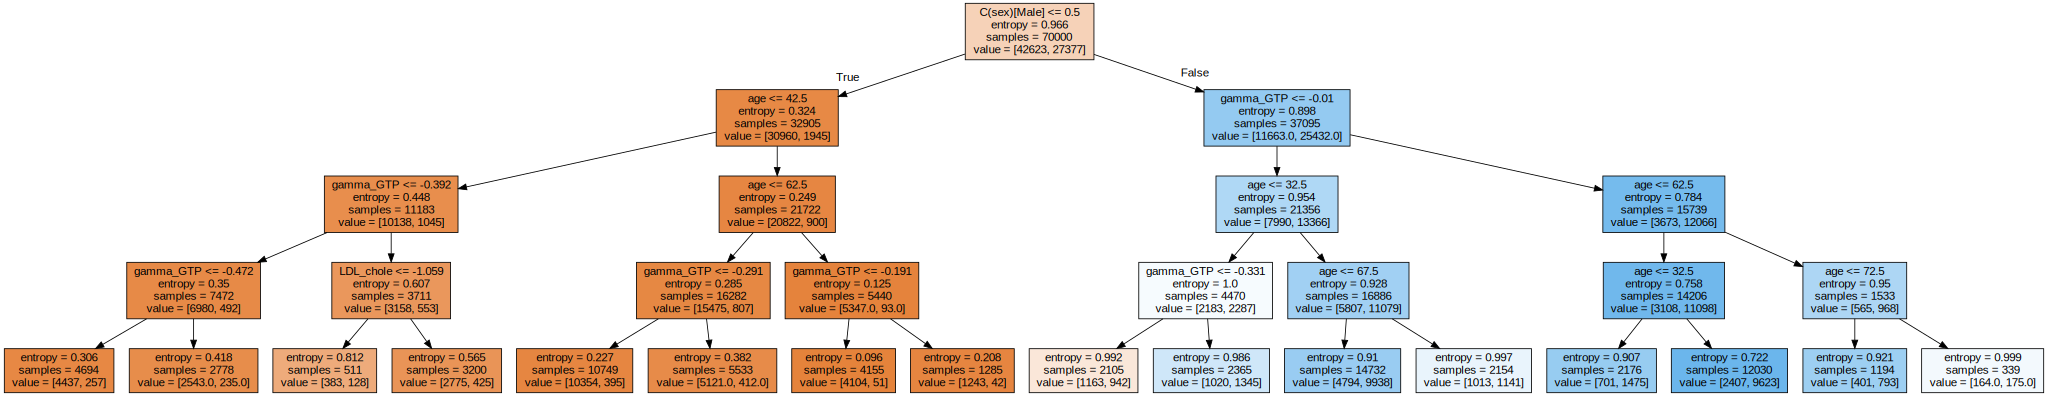

In [243]:
#Don't forget to rename the model and set the max depth
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

#For this it is blue is more positive and red it more negative, white or tan is no split
#80.96 - slight improvement

In [ ]:
#############################################################################################################################

In [245]:
# FE Model: Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('Drinking_Status ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['Drinking_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('max_depth={} avg_score={}'.format(max_depth, scores.mean()))
    #Pick the most simple where it starts leveling out

max_depth=1 avg_score=0.6822714285714285
max_depth=2 avg_score=0.6822714285714285
max_depth=3 avg_score=0.7038714285714287
max_depth=4 avg_score=0.7040571428571429
max_depth=5 avg_score=0.7101142857142857
max_depth=6 avg_score=0.7163571428571428
max_depth=7 avg_score=0.7143999999999999
max_depth=8 avg_score=0.7117000000000001
max_depth=9 avg_score=0.7101714285714286
max_depth=10 avg_score=0.7071000000000001
max_depth=11 avg_score=0.7019714285714285
max_depth=12 avg_score=0.6955857142857143
max_depth=13 avg_score=0.6899714285714286
max_depth=14 avg_score=0.6852714285714285
max_depth=15 avg_score=0.6795714285714287


0.7180333333333333


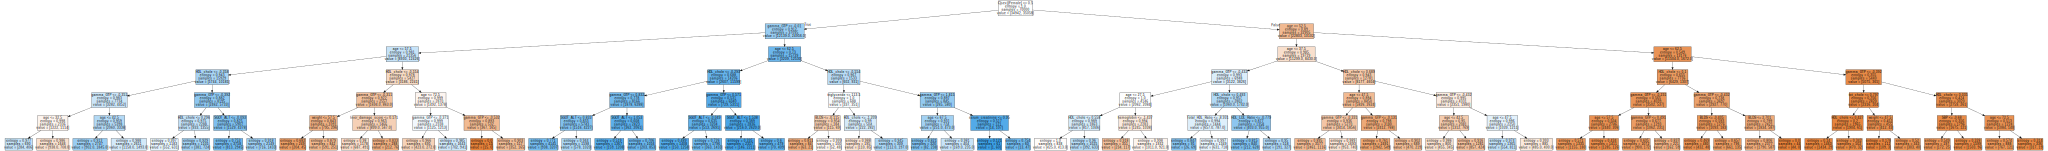

In [249]:
#Don't forget to rename the model and set the max depth
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

#For this it is blue is more positive and red it more negative, white or tan is no split

In [ ]:
#New Important Features are Total_HDL_Ratio, HDL_LDL_Ratio, liver_damage_score

In [ ]:
####################################################################################################################

In [315]:
# FE Model: Smokers and/or Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('DorS ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['DorS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('max_depth={} avg_score={}'.format(max_depth, scores.mean()))
    #Pick the most simple where it starts leveling out

max_depth=1 avg_score=0.7690142857142857
max_depth=2 avg_score=0.7690142857142858
max_depth=3 avg_score=0.7795571428571428
max_depth=4 avg_score=0.7818857142857143
max_depth=5 avg_score=0.7848857142857142
max_depth=6 avg_score=0.7886571428571428
max_depth=7 avg_score=0.7881571428571429
max_depth=8 avg_score=0.7868285714285714
max_depth=9 avg_score=0.7817285714285716
max_depth=10 avg_score=0.7801285714285715
max_depth=11 avg_score=0.7759285714285714
max_depth=12 avg_score=0.7690571428571429
max_depth=13 avg_score=0.7638857142857142
max_depth=14 avg_score=0.7552857142857142
max_depth=15 avg_score=0.7510142857142857


0.7896


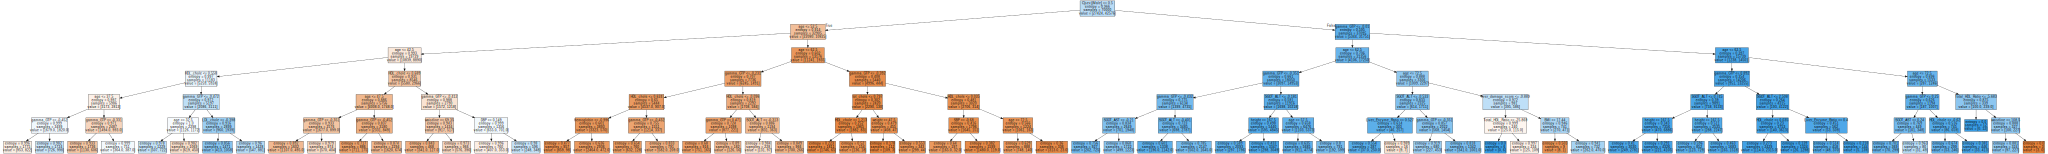

In [316]:
#Don't forget to rename the model and set the max depth
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

#For this it is blue is more positive and red it more negative, white or tan is no split

In [321]:
fig = graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))
fig.render("decision_tree_graphivz")

'decision_tree_graphivz.pdf'

In [ ]:
#New important features are Liver_Enzyme_Ratio, Total_HDL_Ratio

In [ ]:
##################################################################################################################

In [222]:
#Baseline Accuracy:

# Drinkers
print(len(sample_df[sample_df['DRK_YN'] == 'Y'])/len(sample_df))
#If we predict all are drinkers we get an accuracy of 50.2%

# Smokers
print(len(sample_df[sample_df['SMK_stat_type_cd'] == 1])/len(sample_df))
#If we predict all are not smokers we get an accuracy of 60.8%

# Smokers
print(len(sample_df_fe[sample_df_fe['DorS'] == 1])/len(sample_df_fe))
#If we predict all are smokers or drinkers we get an accuracy of 60.9%


0.5019
0.60773
0.60909


In [ ]:
#######################################################################################################

In [279]:
# Bagging - Base Model: Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
sample_df_no_feature_engg3['DRK_YN'] = sample_df_no_feature_engg3['DRK_YN'].apply(lambda x: 1 if x == 'Y' else 0)
Y, X = dmatrices('DRK_YN ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP', sample_df_no_feature_engg3, return_type='dataframe')
y = Y['DRK_YN'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'),random_state=1)
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.695


In [ ]:
#####################################################################################################

In [281]:
# Bagging - Base Model: Smokers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
sample_df_no_feature_engg4['SMK_stat_type_cd'] = sample_df_no_feature_engg4['SMK_stat_type_cd'].apply(lambda x: 0 if x == 1 else 1)
Y, X = dmatrices('SMK_stat_type_cd ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP', sample_df_no_feature_engg4, return_type='dataframe')
y = Y['SMK_stat_type_cd'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'),random_state=1)
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.7839666666666667


In [ ]:
###################################################################################################################

In [283]:
# Bagging - FE Model: Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('Drinking_Status ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['Drinking_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'),random_state=1)
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.6956


In [ ]:
#####################################################################################################

In [344]:
# Bagging - FE Model: Smokers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('Smoking_Status ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['Smoking_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'),random_state=1)
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.7836666666666666


In [ ]:
####################################################################

In [287]:
# Bagging - FE Model: Smokers and/or Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('DorS ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['DorS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'),random_state=1)
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.7737333333333334


In [ ]:
###################################################################

In [34]:
# RF - Base Model: Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
sample_df_no_feature_engg5['DRK_YN'] = sample_df_no_feature_engg6['DRK_YN'].apply(lambda x: 1 if x == 'Y' else 0)
Y, X = dmatrices('DRK_YN ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP', sample_df_no_feature_engg5, return_type='dataframe')
y = Y['DRK_YN'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=100, random_state=1)
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.7259


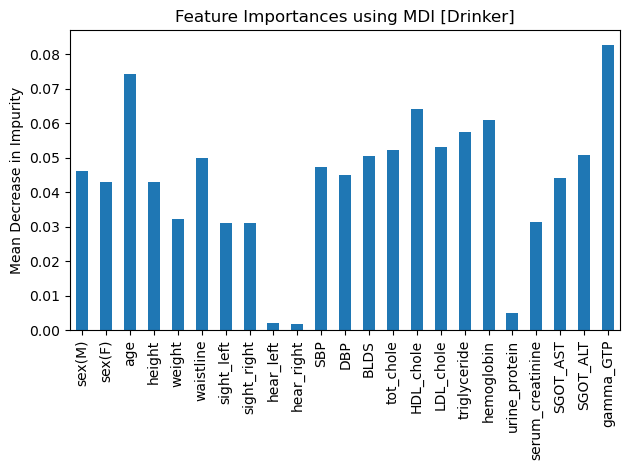

In [36]:
importances = model.feature_importances_
feature_names = [ 'sex(M)', 'sex(F)', 'age', 'height', 'weight', 'waistline',
    'sight_left', 'sight_right',
    'hear_left', 'hear_right',
    'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
    'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine',
    'SGOT_AST', 'SGOT_ALT', 'gamma_GTP'
]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature Importances using MDI [Drinker]")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
#Relative feature importance, its the number of the column
fig.savefig("Feature Importance Drinker.png")

In [26]:
# RF - Base Model: Smokers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
sample_df_no_feature_engg6['SMK_stat_type_cd'] = sample_df_no_feature_engg6['SMK_stat_type_cd'].apply(lambda x: 0 if x == 1 else 1)
Y, X = dmatrices('SMK_stat_type_cd ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP', sample_df_no_feature_engg6, return_type='dataframe')
y = Y['SMK_stat_type_cd'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=100, random_state=1)#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.8083


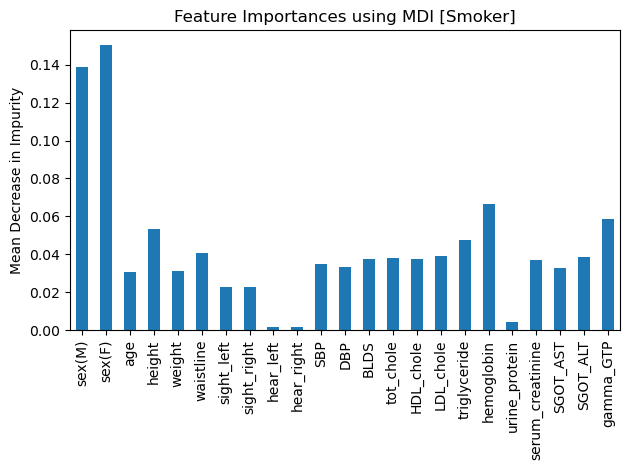

In [27]:
importances = model.feature_importances_
feature_names = [ 'sex(M)', 'sex(F)', 'age', 'height', 'weight', 'waistline',
    'sight_left', 'sight_right',
    'hear_left', 'hear_right',
    'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
    'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine',
    'SGOT_AST', 'SGOT_ALT', 'gamma_GTP'
]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature Importances using MDI [Smoker]")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
#Relative feature importance, its the number of the column
fig.savefig("Feature Importance Smoker.png")

In [22]:
# RF - FE Model: Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('Drinking_Status ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['Drinking_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=100, random_state=1)#Don't forget to rename the model and set the max depth
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.7248666666666667


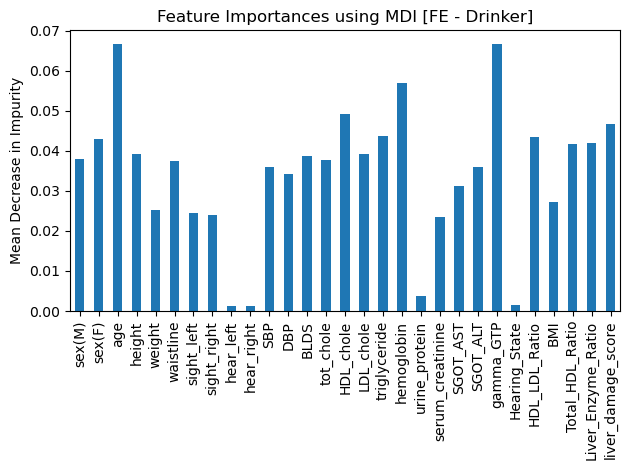

In [23]:
importances = model.feature_importances_
feature_names = [ 'sex(M)', 'sex(F)', 'age', 'height', 'weight', 'waistline',
    'sight_left', 'sight_right',
    'hear_left', 'hear_right',
    'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
    'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine',
    'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'Hearing_State', 'HDL_LDL_Ratio', 'BMI', 'Total_HDL_Ratio', 'Liver_Enzyme_Ratio', 'liver_damage_score'
]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature Importances using MDI [FE - Drinker]")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
#Relative feature importance, its the number of the column
fig.savefig("Feature Importance Drinker FE.png")

In [18]:
# RF - FE Model: Smokers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('Smoking_Status ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['Smoking_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=100, random_state=1)#Don't forget to rename the model and set the max depth
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.8094


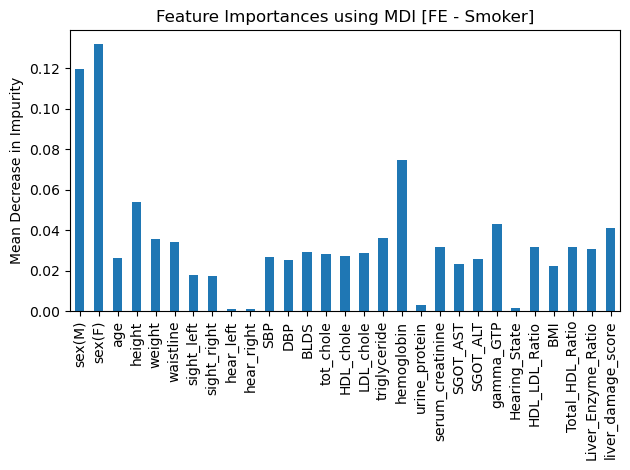

In [20]:
importances = model.feature_importances_
feature_names = [ 'sex(M)', 'sex(F)', 'age', 'height', 'weight', 'waistline',
    'sight_left', 'sight_right',
    'hear_left', 'hear_right',
    'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
    'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine',
    'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'Hearing_State', 'HDL_LDL_Ratio', 'BMI', 'Total_HDL_Ratio', 'Liver_Enzyme_Ratio', 'liver_damage_score'
]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature Importances using MDI [FE - Smoker]")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
#Relative feature importance, its the number of the column
fig.savefig("Feature Importance Smoker FE.png")

In [12]:
# RF - FE Model: Smokers and/or Drinkers

#Model Set Up (include the second line if it is categorical)
#Don't forget to change the predictor variable
Y, X = dmatrices('DorS ~ 0 + C(sex) + age + height + weight + waistline + sight_left + sight_right + hear_left + hear_right + SBP + DBP + BLDS + tot_chole + HDL_chole + LDL_chole + triglyceride + hemoglobin + urine_protein + serum_creatinine + SGOT_AST + SGOT_ALT + gamma_GTP + Hearing_State + HDL_LDL_Ratio + BMI + Total_HDL_Ratio + Liver_Enzyme_Ratio + liver_damage_score', sample_df_fe, return_type='dataframe')
y = Y['DorS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=100, random_state=1)#Don't forget to rename the model and set the max depth
#Don't forget to rename the model and set the max depth
result = model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))
#For this it is blue is more positive and red it more negative, white or tan is no split

0.7924333333333333


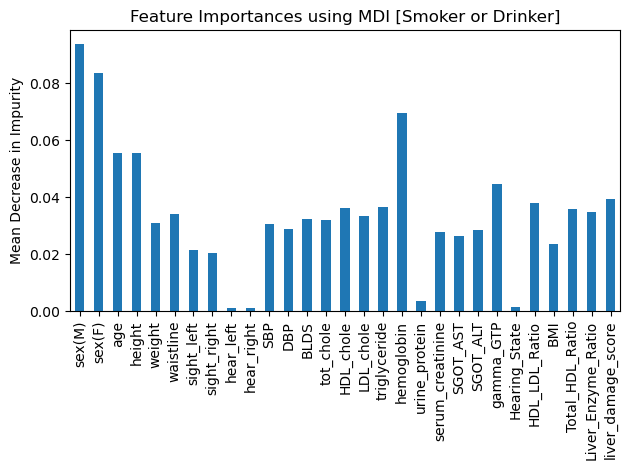

In [16]:
importances = model.feature_importances_
feature_names = [ 'sex(M)', 'sex(F)', 'age', 'height', 'weight', 'waistline',
    'sight_left', 'sight_right',
    'hear_left', 'hear_right',
    'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
    'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine',
    'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'Hearing_State', 'HDL_LDL_Ratio', 'BMI', 'Total_HDL_Ratio', 'Liver_Enzyme_Ratio', 'liver_damage_score'
]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature Importances using MDI [Smoker or Drinker]")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
#Relative feature importance, its the number of the column
fig.savefig("Feature Importance Smoker or Drinker.png")

In [ ]:
##############################################################################################################